In [1]:
# Import packages
import xarray as xr
import proplot as pplt
import warnings
import gcsfs
import intake
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
# abrindo o catálogo de dados
cmip6 = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
cmip6

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [3]:
# dicionário de parâmetros de pesquisa dos dados do CMIP6
pesquisa = dict(experiment_id=['historical', 'ssp245', 'ssp585'],
                table_id='Amon',
                variable_id=['tas'],
                member_id = 'r1i1p1f1',
                grid_label='gr')

In [4]:
# Selecionar grupo CMIP6
cmip6_subset = cmip6.search(require_all_on=['source_id'], **pesquisa)

In [5]:
# Acesso aos dados do filtro
cmip6_dsets = cmip6_subset.to_dataset_dict(aggregate=True,
                                           storage_options={'token': 'anon'},
                                           zarr_kwargs={'consolidated': True,
                                                        'decode_times': True,
                                                        'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [6]:
# criação de uma lista com todas as chaves da seleção de dados
lista_cmip6 = list(cmip6_dsets.keys())
lista_cmip6

['ScenarioMIP.EC-Earth-Consortium.EC-Earth3-Veg-LR.ssp245.Amon.gr',
 'ScenarioMIP.EC-Earth-Consortium.EC-Earth3-Veg.ssp585.Amon.gr',
 'ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp245.Amon.gr',
 'ScenarioMIP.EC-Earth-Consortium.EC-Earth3-Veg-LR.ssp585.Amon.gr',
 'CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr',
 'ScenarioMIP.CAS.FGOALS-f3-L.ssp245.Amon.gr',
 'ScenarioMIP.EC-Earth-Consortium.EC-Earth3.ssp585.Amon.gr',
 'CMIP.EC-Earth-Consortium.EC-Earth3.historical.Amon.gr',
 'CMIP.E3SM-Project.E3SM-1-1.historical.Amon.gr',
 'ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.Amon.gr',
 'ScenarioMIP.THU.CIESM.ssp245.Amon.gr',
 'ScenarioMIP.EC-Earth-Consortium.EC-Earth3.ssp245.Amon.gr',
 'CMIP.EC-Earth-Consortium.EC-Earth3-CC.historical.Amon.gr',
 'ScenarioMIP.EC-Earth-Consortium.EC-Earth3-CC.ssp585.Amon.gr',
 'CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.Amon.gr',
 'CMIP.NIMS-KMA.KACE-1-0-G.historical.Amon.gr',
 'ScenarioMIP.E3SM-Project.E3SM-1-1.ssp245.Amon.gr',
 'ScenarioMIP.E3SM-Project.E3SM-1-1.ssp585.Amon.g

In [7]:
# filtragem de chaves de simulações do modelo CIESM
for i in range(len(lista_cmip6)):
  if 'CIESM' in lista_cmip6[i]: print(lista_cmip6[i])

ScenarioMIP.THU.CIESM.ssp245.Amon.gr
CMIP.THU.CIESM.historical.Amon.gr
ScenarioMIP.THU.CIESM.ssp585.Amon.gr


In [8]:
# filtragem de chaves de simulações do modelo IPSL
for i in range(len(lista_cmip6)):
  if 'IPSL' in lista_cmip6[i]: print(lista_cmip6[i])

ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp245.Amon.gr
CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr
ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.Amon.gr


In [9]:
# filtragem de chaves de simulações do modelo FGOALS
for i in range(len(lista_cmip6)):
  if 'FGOALS' in lista_cmip6[i]: print(lista_cmip6[i])

ScenarioMIP.CAS.FGOALS-f3-L.ssp245.Amon.gr
ScenarioMIP.CAS.FGOALS-f3-L.ssp585.Amon.gr
CMIP.CAS.FGOALS-f3-L.historical.Amon.gr


In [10]:
# filtragem de chaves de simulações do modelo CIESM
for i in range(len(lista_cmip6)):
  if 'EC-Earth3-CC' in lista_cmip6[i]: print(lista_cmip6[i])

CMIP.EC-Earth-Consortium.EC-Earth3-CC.historical.Amon.gr
ScenarioMIP.EC-Earth-Consortium.EC-Earth3-CC.ssp585.Amon.gr
ScenarioMIP.EC-Earth-Consortium.EC-Earth3-CC.ssp245.Amon.gr


In [11]:
import cftime

def to_360day_monthly(da):
    ''' Conversão da dimensão de tempo de modelos climáticos.
        Função criada por Claire Carouge no CLEX CMS Blog'''
    val = da.copy()
    time1 = da.time.copy()
    for itime in range(val.sizes['time']):
        bb = val.time.values[itime].timetuple()
        time1.values[itime] = cftime.Datetime360Day(bb[0],bb[1],16)
    val = val.assign_coords({'time':time1})
    return val

In [12]:
# SETAR NOVAS LAT E LONGS e Resolução
new_lat = pplt.arange(-35, 7, 1)
new_lon = pplt.arange(285, 335, 1)

In [13]:
# historical 
ec_earth3_historical = cmip6_dsets['CMIP.E3SM-Project.E3SM-1-1.historical.Amon.gr']['tas'].squeeze() \
                        .sel(lat=slice(-35, 7), lon=slice(360-75, 360-25)).interp(lat=new_lat, lon=new_lon) - 273.15

ec_earth3_historical = to_360day_monthly(ec_earth3_historical)
ec_earth3_historical

<xarray.DataArray 'tas' (time: 1980, lat: 43, lon: 51)> Size: 17MB
dask.array<sub, shape=(1980, 43, 51), dtype=float32, chunksize=(259, 43, 51), chunktype=numpy.ndarray>
Coordinates:
    height     float64 8B ...
    member_id  <U8 32B 'r1i1p1f1'
  * lat        (lat) int64 344B -35 -34 -33 -32 -31 -30 -29 ... 1 2 3 4 5 6 7
  * lon        (lon) int64 408B 285 286 287 288 289 290 ... 331 332 333 334 335
  * time       (time) object 16kB 1850-01-16 00:00:00 ... 2014-12-16 00:00:00

In [14]:
# historical 
ipsl_historical = cmip6_dsets['CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr']['tas'].squeeze() \
                        .sel(lat=slice(-35, 7), lon=slice(360-75, 360-25)).interp(lat=new_lat, lon=new_lon) - 273.15

ipsl_historical = to_360day_monthly(ipsl_historical)
ipsl_historical

<xarray.DataArray 'tas' (time: 1980, lat: 43, lon: 51)> Size: 17MB
dask.array<sub, shape=(1980, 43, 51), dtype=float32, chunksize=(600, 43, 51), chunktype=numpy.ndarray>
Coordinates:
    height     float64 8B ...
    member_id  <U8 32B 'r1i1p1f1'
  * lat        (lat) int64 344B -35 -34 -33 -32 -31 -30 -29 ... 1 2 3 4 5 6 7
  * lon        (lon) int64 408B 285 286 287 288 289 290 ... 331 332 333 334 335
  * time       (time) object 16kB 1850-01-16 00:00:00 ... 2014-12-16 00:00:00

In [15]:
# historical 
ciesm_historical = cmip6_dsets['CMIP.THU.CIESM.historical.Amon.gr']['tas'].squeeze() \
                        .sel(lat=slice(-35, 7), lon=slice(360-75, 360-25)).interp(lat=new_lat, lon=new_lon) - 273.15

ciesm_historical = to_360day_monthly(ciesm_historical)
ciesm_historical

<xarray.DataArray 'tas' (time: 1980, lat: 43, lon: 51)> Size: 17MB
dask.array<sub, shape=(1980, 43, 51), dtype=float32, chunksize=(302, 43, 51), chunktype=numpy.ndarray>
Coordinates:
    height     float64 8B ...
    member_id  <U8 32B 'r1i1p1f1'
  * lat        (lat) int64 344B -35 -34 -33 -32 -31 -30 -29 ... 1 2 3 4 5 6 7
  * lon        (lon) int64 408B 285 286 287 288 289 290 ... 331 332 333 334 335
  * time       (time) object 16kB 1850-01-16 00:00:00 ... 2014-12-16 00:00:00

In [16]:
# historical 
fgoals_historical = cmip6_dsets['CMIP.CAS.FGOALS-f3-L.historical.Amon.gr']['tas'].squeeze() \
                        .sel(lat=slice(-35, 7), lon=slice(360-75, 360-25)).interp(lat=new_lat, lon=new_lon) - 273.15

fgoals_historical = to_360day_monthly(fgoals_historical)
fgoals_historical

<xarray.DataArray 'tas' (time: 1980, lat: 43, lon: 51)> Size: 17MB
dask.array<sub, shape=(1980, 43, 51), dtype=float32, chunksize=(241, 43, 51), chunktype=numpy.ndarray>
Coordinates:
    height     float64 8B ...
    member_id  <U8 32B 'r1i1p1f1'
  * lat        (lat) int64 344B -35 -34 -33 -32 -31 -30 -29 ... 1 2 3 4 5 6 7
  * lon        (lon) int64 408B 285 286 287 288 289 290 ... 331 332 333 334 335
  * time       (time) object 16kB 1850-01-16 00:00:00 ... 2014-12-16 00:00:00

In [17]:
# ensembles
ensemble_historical = (ciesm_historical + ec_earth3_historical + ipsl_historical + fgoals_historical) / 4.
ensemble_historical

<xarray.DataArray 'tas' (time: 1980, lat: 43, lon: 51)> Size: 17MB
dask.array<truediv, shape=(1980, 43, 51), dtype=float32, chunksize=(241, 43, 51), chunktype=numpy.ndarray>
Coordinates:
    height     float64 8B 2.0
    member_id  <U8 32B 'r1i1p1f1'
  * lat        (lat) int64 344B -35 -34 -33 -32 -31 -30 -29 ... 1 2 3 4 5 6 7
  * lon        (lon) int64 408B 285 286 287 288 289 290 ... 331 332 333 334 335
  * time       (time) object 16kB 1850-01-16 00:00:00 ... 2014-12-16 00:00:00

In [18]:
# Normal climatológica Temp Ar Ensemble
tas_media_historical = ensemble_historical.sel(time=slice('1850-01-16', '1900-12-16')) \
                                          .groupby('time.month').mean('time')
tas_media_historical

<xarray.DataArray 'tas' (month: 12, lat: 43, lon: 51)> Size: 105kB
dask.array<stack, shape=(12, 43, 51), dtype=float32, chunksize=(1, 43, 51), chunktype=numpy.ndarray>
Coordinates:
    height     float64 8B 2.0
    member_id  <U8 32B 'r1i1p1f1'
  * lat        (lat) int64 344B -35 -34 -33 -32 -31 -30 -29 ... 1 2 3 4 5 6 7
  * lon        (lon) int64 408B 285 286 287 288 289 290 ... 331 332 333 334 335
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

In [19]:
# Diferença entre um período recente (1981~2010) menos a climatologia (1850-1900)
anom_tas_recente = ensemble_historical.sel(time=slice('1981-01-16', '2010-12-16')).mean('time') - tas_media_historical.mean('month')
anom_tas_recente

<xarray.DataArray 'tas' (lat: 43, lon: 51)> Size: 9kB
dask.array<sub, shape=(43, 51), dtype=float32, chunksize=(43, 51), chunktype=numpy.ndarray>
Coordinates:
    height     float64 8B 2.0
    member_id  <U8 32B 'r1i1p1f1'
  * lat        (lat) int64 344B -35 -34 -33 -32 -31 -30 -29 ... 1 2 3 4 5 6 7
  * lon        (lon) int64 408B 285 286 287 288 289 290 ... 331 332 333 334 335

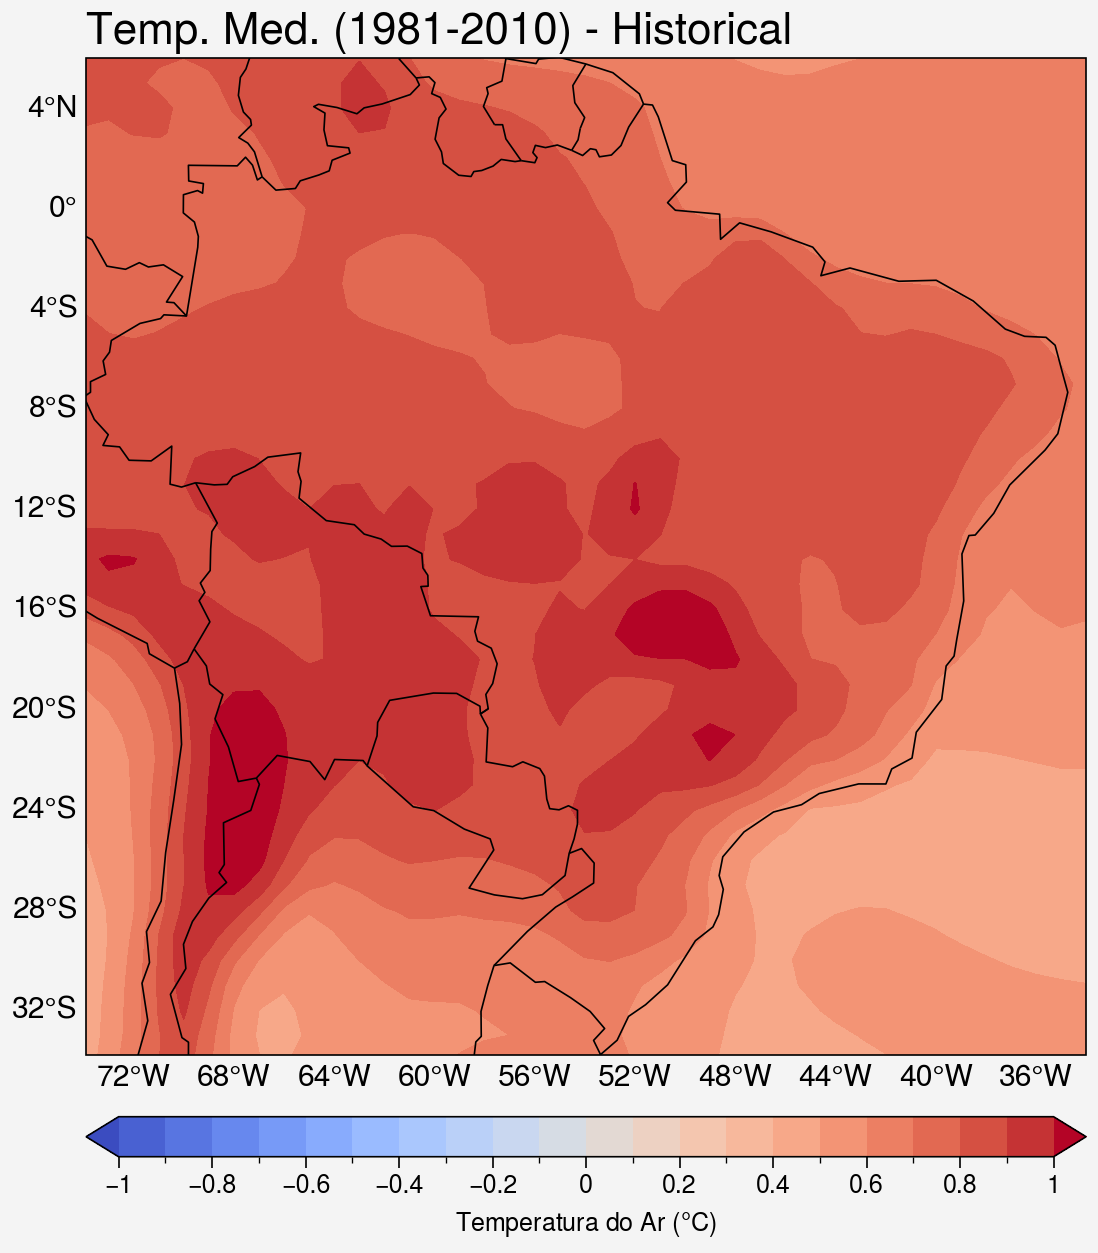

In [20]:
# Plot
fig, ax = pplt.subplots(axwidth=5.0, ncols=1, tight=True,
                        proj='pcarree', proj_kw={'lon_0':0})

# parâmetros de formatação do mapa
ax.format(land=False, coast=True, innerborders=False,
          borders=True, labels=True, grid=True,
          latlim=(-33.8, 6), lonlim=(-73.9, -34),
          latlines=4, lonlines=4, geogridlinewidth=0,
          small='15px', large='22px')
ax.format(ltitle='Temp. Med. (1981-2010) - Historical')

#
map1 = ax.contourf(anom_tas_recente['lon'], anom_tas_recente['lat'],
                   anom_tas_recente,
                   cmap='coolwarm', levels=pplt.arange(-1, 1, 0.1),
                   extend='both')

# barra de cores
fig.colorbar(map1, loc='b', label='Temperatura do Ar ($\degree$C)')

pplt.show()

In [21]:
# ndarray de pesos calculados a partir do cosseno de pontos de latitude
weights = np.cos(np.deg2rad(ensemble_historical['lat']))
weights.name = "weights"
weights

<xarray.DataArray 'weights' (lat: 43)> Size: 344B
array([0.81915204, 0.82903757, 0.83867057, 0.8480481 , 0.8571673 ,
       0.8660254 , 0.87461971, 0.88294759, 0.89100652, 0.89879405,
       0.90630779, 0.91354546, 0.92050485, 0.92718385, 0.93358043,
       0.93969262, 0.94551858, 0.95105652, 0.95630476, 0.9612617 ,
       0.96592583, 0.97029573, 0.97437006, 0.9781476 , 0.98162718,
       0.98480775, 0.98768834, 0.99026807, 0.99254615, 0.9945219 ,
       0.9961947 , 0.99756405, 0.99862953, 0.99939083, 0.9998477 ,
       1.        , 0.9998477 , 0.99939083, 0.99862953, 0.99756405,
       0.9961947 , 0.9945219 , 0.99254615])
Coordinates:
    height     float64 8B 2.0
    member_id  <U8 32B 'r1i1p1f1'
  * lat        (lat) int64 344B -35 -34 -33 -32 -31 -30 -29 ... 1 2 3 4 5 6 7
Attributes:
    axis:           Y
    bounds:         lat_bnds
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north

In [22]:
anom_area_tas_historical = (ensemble_historical.groupby('time.month') - tas_media_historical)\
                           .weighted(weights).mean(dim=('lon', 'lat')).resample(time='1Y').mean('time')

In [23]:
# temperatura do ar da reanálise NOAA
reanalise_t2m = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/NOAA_20th_Century/V3/monthly/monolevel/2m_air')
reanalise_t2m

<xarray.Dataset> Size: 563MB
Dimensions:  (time: 2160, lat: 181, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 17kB 1836-01-01 1836-02-01 ... 2015-12-01
  * lat      (lat) float64 1kB -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Data variables:
    air      (time, lat, lon) float32 563MB ...
Attributes:
    title:          Monthly NOAA/CIRES/DOE 20th Century Reanalysis V3
    Conventions:    COARDS\nGrADS
    dataType:       Grid
    documentation:  http://apdrc.soest.hawaii.edu/datadoc/20century_reanalysi...
    history:        Tue Apr 30 05:42:23 HST 2024 : imported by GrADS Data Ser...

In [24]:
# recorte espacial e interpolação dos dados
reanalise_t2m = reanalise_t2m['air'].sel(lat=slice(-35, 7), lon=slice(360-75, 360-25)) \
                                    .interp(lat=new_lat, lon=new_lon)

In [25]:
# média do período pré-industrial
t2m_media_reanalise = reanalise_t2m.sel(time=slice('1850-01-16', '1900-12-16')) \
                                        .groupby('time.month').mean('time')

In [26]:
# anomalias de temperatura e média ponderada em área
anom_t2m_reanalise = (reanalise_t2m.groupby('time.month') - t2m_media_reanalise)\
                      .weighted(weights).mean(dim=('lon', 'lat')).resample(time='1Y').mean('time')\
                      .sel(time=slice('1850-01-01', '2014-12-31'))

In [27]:
anom_tas_ciesm = (ciesm_historical.groupby('time.month') - ciesm_historical.sel(time=slice('1850-01-16', '1900-12-16')).groupby('time.month').mean('time'))\
                  .weighted(weights).mean(dim=('lon', 'lat')).resample(time='1Y').mean('time')

In [28]:
anom_tas_ec_earth3 = (ec_earth3_historical.groupby('time.month') - ec_earth3_historical.sel(time=slice('1850-01-16', '1900-12-16')).groupby('time.month').mean('time'))\
                      .weighted(weights).mean(dim=('lon', 'lat')).resample(time='1Y').mean('time')

In [29]:
anom_tas_ipsl = (ipsl_historical.groupby('time.month') - ipsl_historical.sel(time=slice('1850-01-16', '1900-12-16')).groupby('time.month').mean('time'))\
                 .weighted(weights).mean(dim=('lon', 'lat')).resample(time='1Y').mean('time')

In [30]:
anom_tas_fgoals = (fgoals_historical.groupby('time.month') - fgoals_historical.sel(time=slice('1850-01-16', '1900-12-16')).groupby('time.month').mean('time'))\
                 .weighted(weights).mean(dim=('lon', 'lat')).resample(time='1Y').mean('time')

In [31]:
# importar skillmetrics
import skill_metrics as sm

In [32]:
taylor_ensemble = sm.taylor_statistics(anom_area_tas_historical.values, anom_t2m_reanalise.values, 'ensemble')
taylor_ciesm = sm.taylor_statistics(anom_tas_ciesm.values, anom_t2m_reanalise.values, 'ciesm')
taylor_ec_earth3 = sm.taylor_statistics(anom_tas_ec_earth3.values, anom_t2m_reanalise.values, 'ec_earth3')
taylor_ipsl = sm.taylor_statistics(anom_tas_ipsl.values, anom_t2m_reanalise.values, 'ipsl')
taylor_fgoals = sm.taylor_statistics(anom_tas_fgoals.values, anom_t2m_reanalise.values, 'fgoals')

In [33]:
taylor_ciesm

{'ccoef': array([1.        , 0.56967119]),
 'crmsd': [0.0, 0.43291677538330076],
 'sdev': [0.2819933054772129, 0.526297713543156]}

In [34]:
sdev = np.array([taylor_ciesm['sdev'][0], taylor_ensemble['sdev'][1],
                 taylor_ciesm['sdev'][1], taylor_ec_earth3['sdev'][1], taylor_ipsl['sdev'][1], taylor_fgoals['sdev'][1]])

rmsd = np.array([taylor_ciesm['crmsd'][0], taylor_ensemble['crmsd'][1],
                 taylor_ciesm['crmsd'][1], taylor_ec_earth3['crmsd'][1], taylor_ipsl['crmsd'][1], taylor_fgoals['crmsd'][1]])

ccoef = np.array([taylor_ciesm['ccoef'][0], taylor_ensemble['ccoef'][1],
                  taylor_ciesm['ccoef'][1], taylor_ec_earth3['ccoef'][1], taylor_ipsl['ccoef'][1], taylor_fgoals['ccoef'][1]])

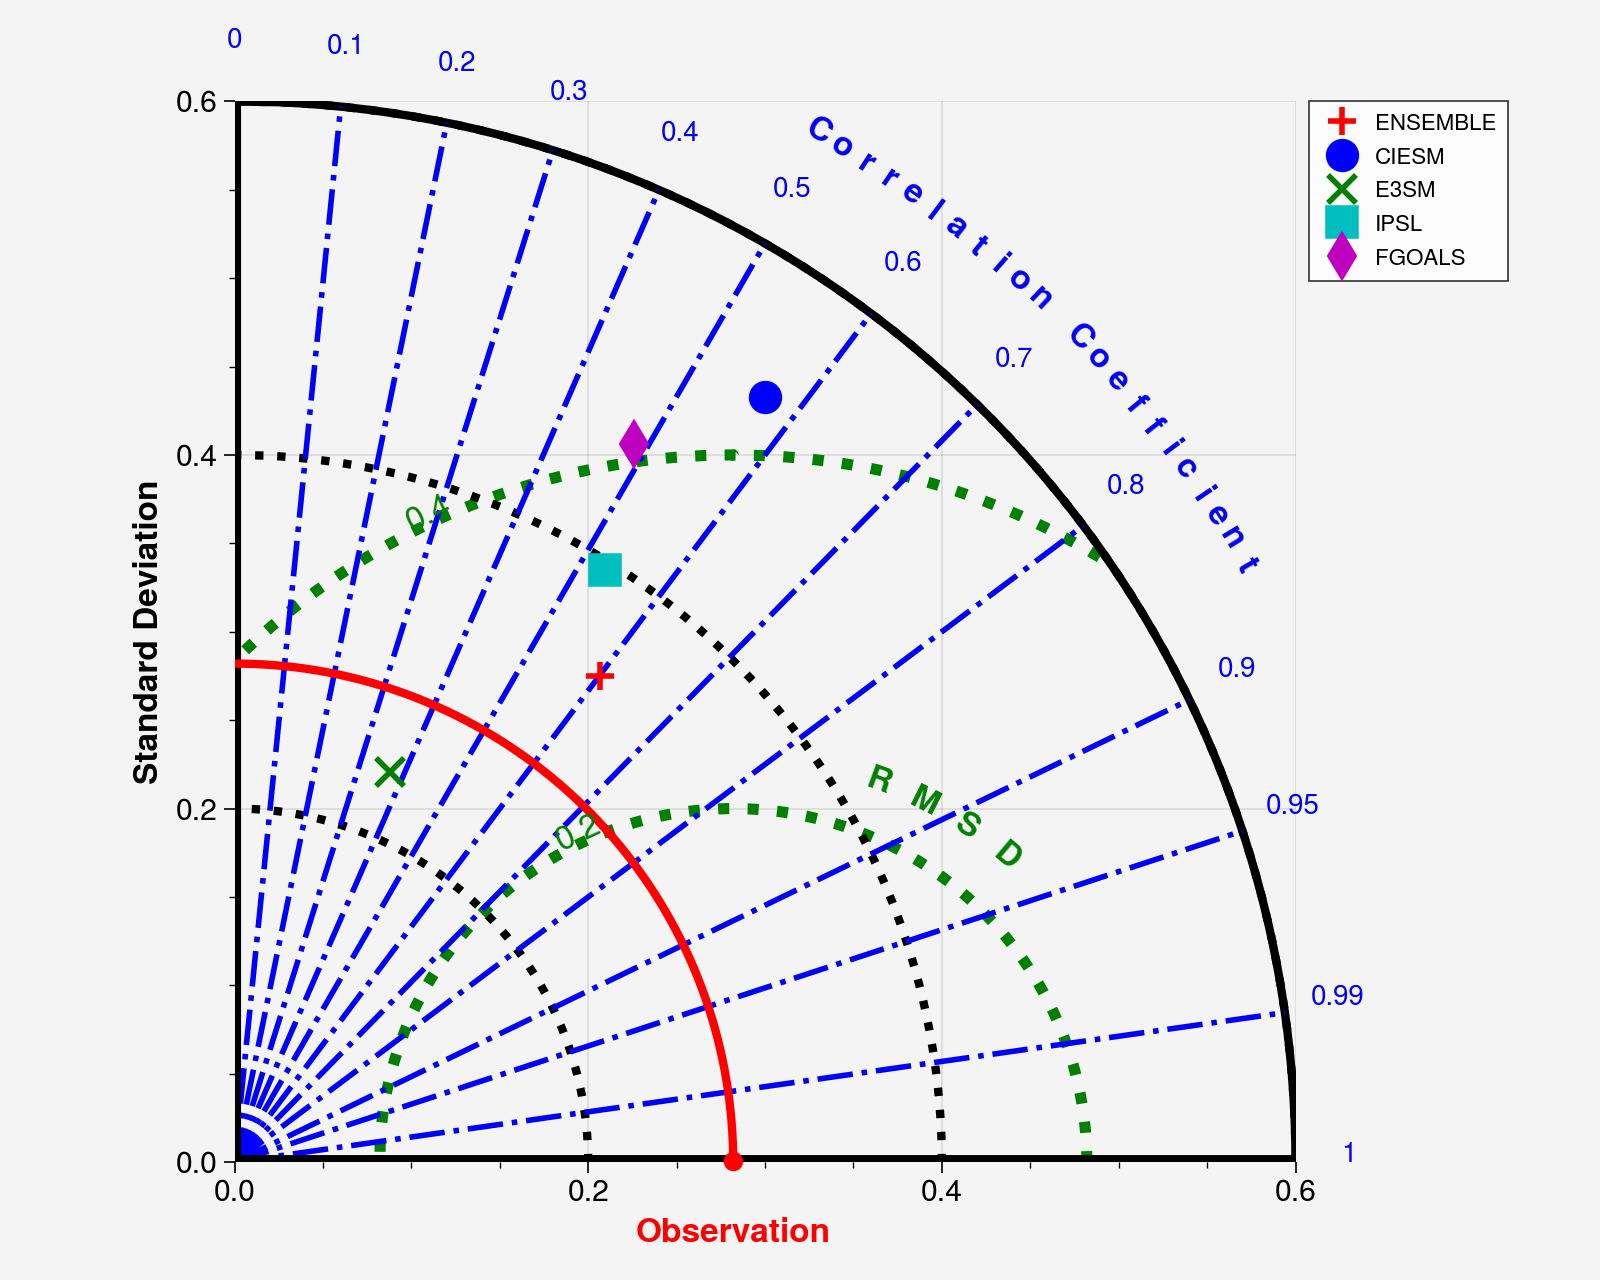

In [35]:
import argparse
from matplotlib import rcParams

# Set the figure properties (optional)
rcParams["figure.figsize"] = [8.0, 6.4]
rcParams['lines.linewidth'] = 3 # line width for plots
rcParams.update({'font.size': 10}) # font size of axes text

plt.figure()

sm.taylor_diagram(sdev, rmsd, ccoef,
                  markerlabel = ['OBS', 'ENSEMBLE', 'CIESM', 'E3SM', 'IPSL', 'FGOALS'],
                  styleobs = '-', colobs = 'r', markerobs = 'o', titleOBS = 'Observation',
                  colRMS = 'g', styleRMS = ':', widthRMS = 4.0,
                  titleRMS = 'on', titleRMSDangle = 60.0,
                  tickrms = np.arange(0.2, 0.6, 0.2),
                  markerLegend = 'on', widthCOR = 2.0)

plt.tight_layout()
plt.show()

Elaborar Mapa Viés

In [36]:
# temperatura do ar da reanálise NOAA
reanalise_t2m = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/NOAA_20th_Century/V3/monthly/monolevel/2m_air')
reanalise_t2m

<xarray.Dataset> Size: 563MB
Dimensions:  (time: 2160, lat: 181, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 17kB 1836-01-01 1836-02-01 ... 2015-12-01
  * lat      (lat) float64 1kB -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Data variables:
    air      (time, lat, lon) float32 563MB ...
Attributes:
    title:          Monthly NOAA/CIRES/DOE 20th Century Reanalysis V3
    Conventions:    COARDS\nGrADS
    dataType:       Grid
    documentation:  http://apdrc.soest.hawaii.edu/datadoc/20century_reanalysi...
    history:        Tue Apr 30 05:42:23 HST 2024 : imported by GrADS Data Ser...

In [37]:
# recorte espacial e interpolação dos dados
reanalise_t2m = reanalise_t2m['air'].sel(lat=slice(-35, 7), lon=slice(360-75, 360-25)) \
                                    .interp(lat=new_lat, lon=new_lon)

In [39]:
# média do período pré-industrial
t2m_media_reanalise = reanalise_t2m.sel(time=slice('1850-01-16', '1900-12-16')) \
                                        .groupby('time.month').mean('time')
t2m_media_reanalise

<xarray.DataArray 'air' (month: 12, lat: 43, lon: 51)> Size: 211kB
array([[[289.59223328, 289.32664795, 289.63403198, ..., 291.80569031,
         291.78817261, 291.75115479],
        [289.87282471, 289.66223267, 289.87916992, ..., 292.67498657,
         292.70692017, 292.68395264],
        [290.23617737, 290.04934265, 289.98545593, ..., 293.53616699,
         293.5726239 , 293.55309692],
        ...,
        [290.84330505, 288.34550659, 291.36989807, ..., 298.77802368,
         298.78958374, 298.81051208],
        [292.66080566, 293.45120789, 286.75412415, ..., 298.51734863,
         298.51779663, 298.54263428],
        [294.14180603, 298.31849304, 290.20887939, ..., 298.22386414,
         298.22398315, 298.26990112]],

       [[289.89164704, 289.47281901, 289.67430982, ..., 292.75024534,
         292.72360529, 292.65075803],
        [290.1790939 , 289.85674032, 289.98098815, ..., 293.68127023,
         293.68090222, 293.60768816],
        [290.61879296, 290.35371369, 290.15804994, ..., 294.56525556,
         294.55766745, 294.49782966],
...
        [290.27893784, 288.03847249, 291.53415515, ..., 299.48545089,
         299.49754064, 299.49780692],
        [292.16333546, 292.76777858, 286.76266958, ..., 299.60784972,
         299.63982676, 299.66352276],
        [293.43263215, 297.3653355 , 289.61422909, ..., 299.65966079,
         299.70060521, 299.74535475]],

       [[288.28508026, 288.12269622, 288.48961505, ..., 290.04473338,
         290.02618109, 290.01081758],
        [288.61154833, 288.46776207, 288.71830002, ..., 290.81541233,
         290.84876865, 290.88361912],
        [288.93095727, 288.7878388 , 288.72272207, ..., 291.55284268,
         291.61653047, 291.67260263],
        ...,
        [290.23180494, 287.87890565, 291.11541509, ..., 299.26384062,
         299.29003009, 299.30294142],
        [292.10179886, 292.69958855, 286.55190621, ..., 299.17945652,
         299.20898737, 299.23203113],
        [293.45305798, 297.37962311, 289.55345303, ..., 299.02133598,
         299.05627322, 299.09607951]]])
Coordinates:
  * lat      (lat) int64 344B -35 -34 -33 -32 -31 -30 -29 -28 ... 1 2 3 4 5 6 7
  * lon      (lon) int64 408B 285 286 287 288 289 290 ... 331 332 333 334 335
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:  monthly air temperature at 2 m